In [311]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [312]:
prod_data = pd.read_csv('production_data.csv')
wells_data =  pd.read_csv('wellsData.csv')
op_aliasing_data = pd.read_csv('operator_aliasing.csv')

C:\Users\Dell\Anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (21,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [313]:
# Dropping duplicates from prod_data 
prod_data = prod_data.drop_duplicates(subset=['API', 'Month', 'Year'], keep='last', inplace=False)

In [314]:
# dropping unnecessary columns from tables
cols = ['API', 'Year', 'Month', 'Liquid', 'Gas', 'RatioGasOil']
prod_data = prod_data[cols]

cols = ['API', 'SpudDate', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

cols = ['Name', 'Alias']
op_aliasing_data = op_aliasing_data[cols]

In [315]:
# adding zeros to API
wells_data['API'] = (wells_data['API']).astype(str)
wells_data['API'] = wells_data['API'].apply(lambda x: x.zfill(14))

In [316]:
# adding zeros to API
prod_data['API'] = (prod_data['API']).astype(str)
prod_data['API'] = prod_data['API'].apply(lambda x: x.zfill(14))

In [317]:
# renaming operators
alias_dict = dict(zip(op_aliasing_data.Name, op_aliasing_data.Alias))
wells_data['operatorNameIHS'] = wells_data['operatorNameIHS'].map(alias_dict).fillna(wells_data['operatorNameIHS'])

In [321]:
idx_max = prod_data.groupby(['API'])['Liquid'].transform('max') == prod_data['Liquid']
max_month_prod_data = prod_data[idx_max].drop_duplicates(subset='API', keep='first', inplace=False)
list_indices = ['API', 'Year', 'Month', 'Liquid']
max_month_prod_data = max_month_prod_data[list_indices]
max_month_prod_data = max_month_prod_data.rename(columns={"Year": "Max_Year", "Month": "Max_Month", "Liquid": "Max_Liquid"})

In [322]:
# merging the two dataframes to get max month and max year
new_prod_data_orig = prod_data.merge(max_month_prod_data, on='API')

In [328]:
# Remove Pre-Peak Months (clean up)
new_prod_data = new_prod_data_orig[((new_prod_data_orig['Year'] == new_prod_data_orig['Max_Year']))]
new_prod_data = new_prod_data[(new_prod_data['Month'] >= new_prod_data['Max_Month'])]

new_prod_data2 = new_prod_data_orig[((new_prod_data_orig['Year'] > new_prod_data_orig['Max_Year']))]
new_prod_data3 = new_prod_data.append(new_prod_data2)

In [329]:
def calc_month_index(max_year, max_month, year, month):
    return (12 - max_month + (year - max_year - 1)*12 + month) * (year != max_year) + (year == max_year) * (month - max_month) + 1 

In [330]:
new_prod_data3['index'] = calc_month_index(new_prod_data3['Max_Year'], new_prod_data3['Max_Month'], new_prod_data3['Year'], new_prod_data3['Month'])
indexed_prod_data = new_prod_data3

# Problems encountered

## 1) 0 max liquid production, fixed by setting first month as peek month
## 2) missing months data in indexing months, fixed by super smart indexing equation
## 3) missing month data in plotting, will be fixed by moving average inshaAllah
## 4) UNKNOWN alias and operator
## 5) CompletionDate removed Nulls and replaced them with Non-null Spuddates + six months
## 6) removed duplicate entries for API, Month, Year by keeping the last updated one
## 7) Data Zeft
## 8) removed null spuddates and null completion dates from wells_data

In [333]:
# removed nullified SpudDates and CompletionDates
wells_data = wells_data[~((wells_data['SpudDate'].isnull()) & (wells_data['CompletionDate'].isnull()))]

In [334]:
# replacing null CompletionDates with SpudDates + six months
wells_data['SpudDate'] = pd.to_datetime(wells_data['SpudDate'])
wells_data['CompletionDate'] = pd.to_datetime(wells_data['CompletionDate'])
wells_data.loc[wells_data['CompletionDate'].isnull(), 'CompletionDate'] = wells_data['SpudDate'] + timedelta(days=170) 

In [336]:
# Dropping SpudDate column
cols = ['API', 'CompletionDate', 'operatorNameIHS', 'BasinName']
wells_data = wells_data[cols]

In [337]:
wells_data_4basins = wells_data[wells_data['BasinName'] == 'DENVER BASIN']
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'PERMIAN BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'ANADARKO BASIN'])
wells_data_4basins = wells_data_4basins.append(wells_data[wells_data['BasinName'] == 'WILLISTON BASIN'])
wells_data_4basins['API'] = wells_data_4basins['API'].astype(str)

In [339]:
indexed_wells_4basins = wells_data_4basins.merge(indexed_prod_data, on='API')

In [340]:
def get_stats(basin, index, table):
    group = table[(table['BasinName'] == basin) & (table['index'] == index)]
    group_liquid = group["Liquid"]
    mean = group_liquid.mean()
    median = group_liquid.median()
    perct = group_liquid.quantile(.9)
    liquid = group_liquid
    return [[mean], [median], [perct], liquid]

In [341]:
pre2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] < '2014-01-01']
post2014 = indexed_wells_4basins[indexed_wells_4basins['CompletionDate'] >= '2014-01-01']
indices = np.arange(36) + 1
basins = ["ANADARKO BASIN","DENVER BASIN", "PERMIAN BASIN", "WILLISTON BASIN"]

all_stats_pre = np.array([[get_stats(y, x, pre2014) for x in indices] for y in basins]) 
all_stats_post = np.array([[get_stats(y, x, post2014) for x in indices] for y in basins]) 

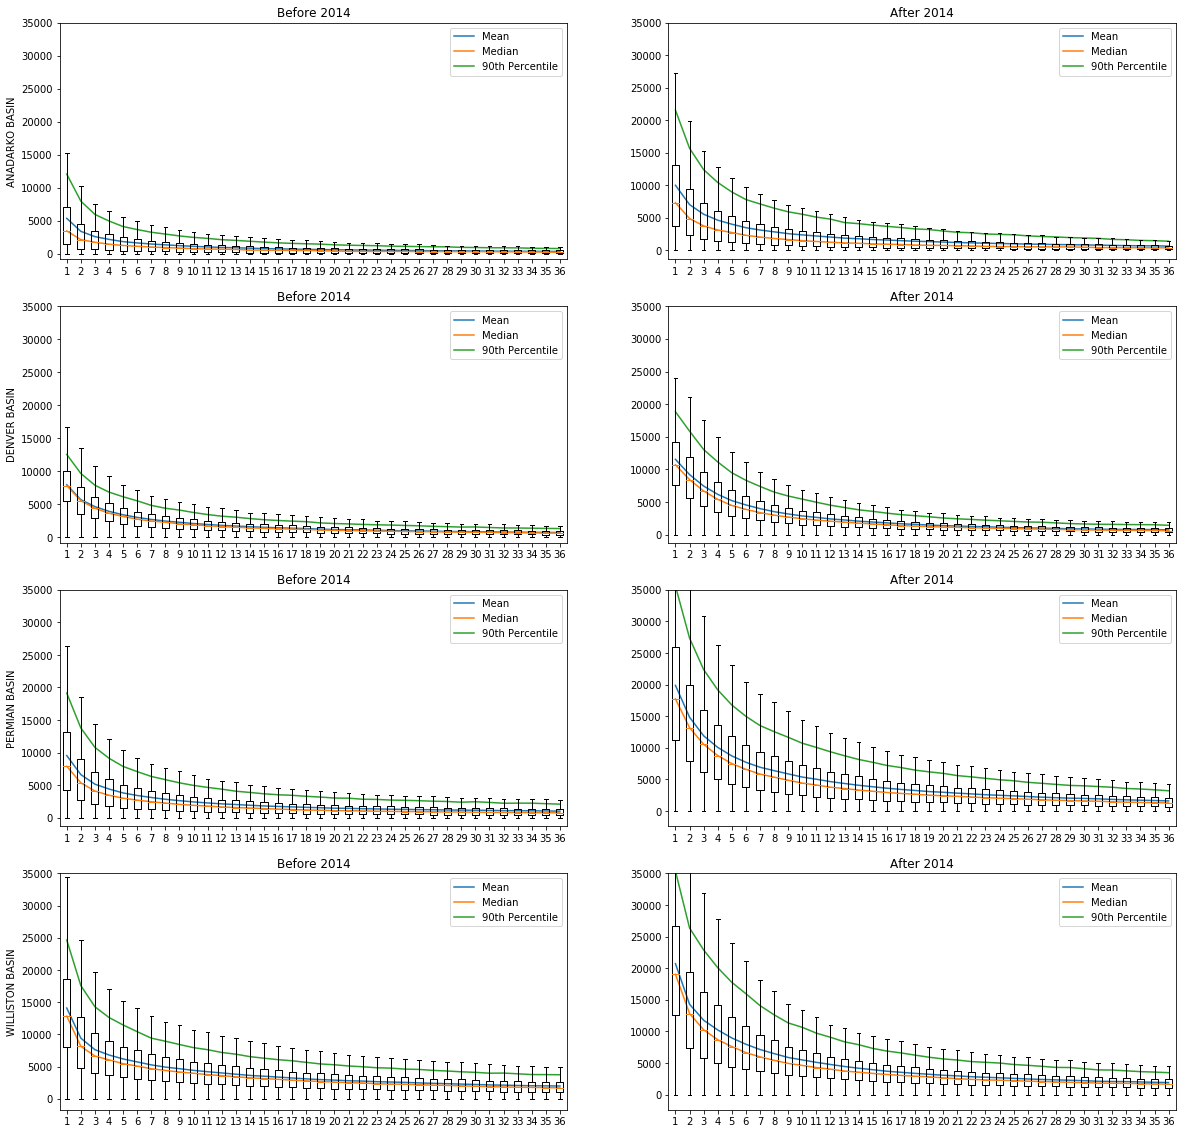

In [342]:
plt.rcParams["figure.figsize"]=20,20

idx = 1
for i in range(len(basins)):

    ax1 = plt.subplot(4,2,idx)
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,0]), label="Mean")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,1]), label="Median")
    ax1.plot(indices, np.hstack(all_stats_pre[i,:,2]), label="90th Percentile")
    ax1.boxplot(list(all_stats_pre[i,:,3]), showfliers=False)
    ax1.set_ylim(top=35000)
    ax1.legend()
    ax1.set_title('Before 2014')
    ax1.set_ylabel(basins[i])
    idx += 1

    ax2 = plt.subplot(4,2,idx)
    ax2.plot(indices, np.hstack(all_stats_post[i,:,0]), label="Mean")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,1]), label="Median")
    ax2.plot(indices, np.hstack(all_stats_post[i,:,2]), label="90th Percentile")
    ax2.boxplot(list(all_stats_post[i,:,3]), showfliers=False)
    ax2.set_ylim(top=35000)
    ax2.set_title('After 2014')
    ax2.legend()
    
    idx += 1
    
plt.savefig('part1.png')



In [343]:
#remove months larger than 60
five_years_data = indexed_wells_4basins
five_years_data['max_index_five_years'] = five_years_data['index'].groupby(five_years_data['API']).transform("max")
five_years_data = five_years_data[five_years_data['max_index_five_years'] >= 60]
five_years_data = five_years_data[five_years_data['index'] <= 60]

In [344]:
def cumm_prod_basin_year(basin, table): #14089 5974
    total = table[(table['BasinName'] == basin)]
    total_liquid = total["Liquid"].sum()
    percents = np.zeros(5)
    for year in range(5):
        lower = (year)*12
        upper = (year + 1)*12
        group = total[(total['index'] > lower) & (total['index'] <= upper)]['Liquid']
        group_liquid = group.sum()
        percents[year] = ((group_liquid*100)/total_liquid)                
        
    return percents
    

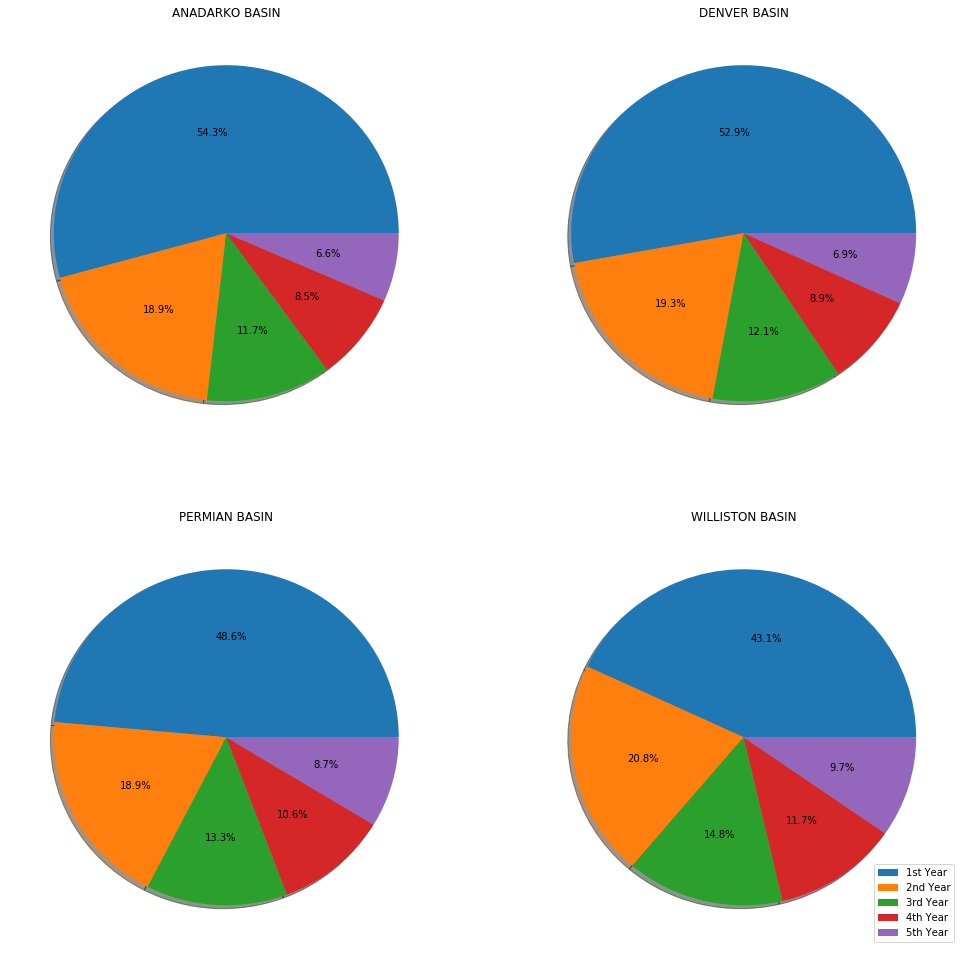

In [345]:
percentages = [cumm_prod_basin_year(y, five_years_data) for y in basins ]

plt.rcParams["figure.figsize"]=17,17
labels = ['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year']
for i in range(len(basins)):

    ax1 = plt.subplot(2,2,i+1)
    ax1.pie(percentages[i], autopct='%1.1f%%', shadow=True)
    ax1.set_title(basins[i])

plt.legend(labels, loc=4)
plt.savefig('Plot2.png')
    

49762.024820378836 ANADARKO BASIN
81121.43232044199 DENVER BASIN
104778.38335644937 PERMIAN BASIN
180867.05691329093 WILLISTON BASIN


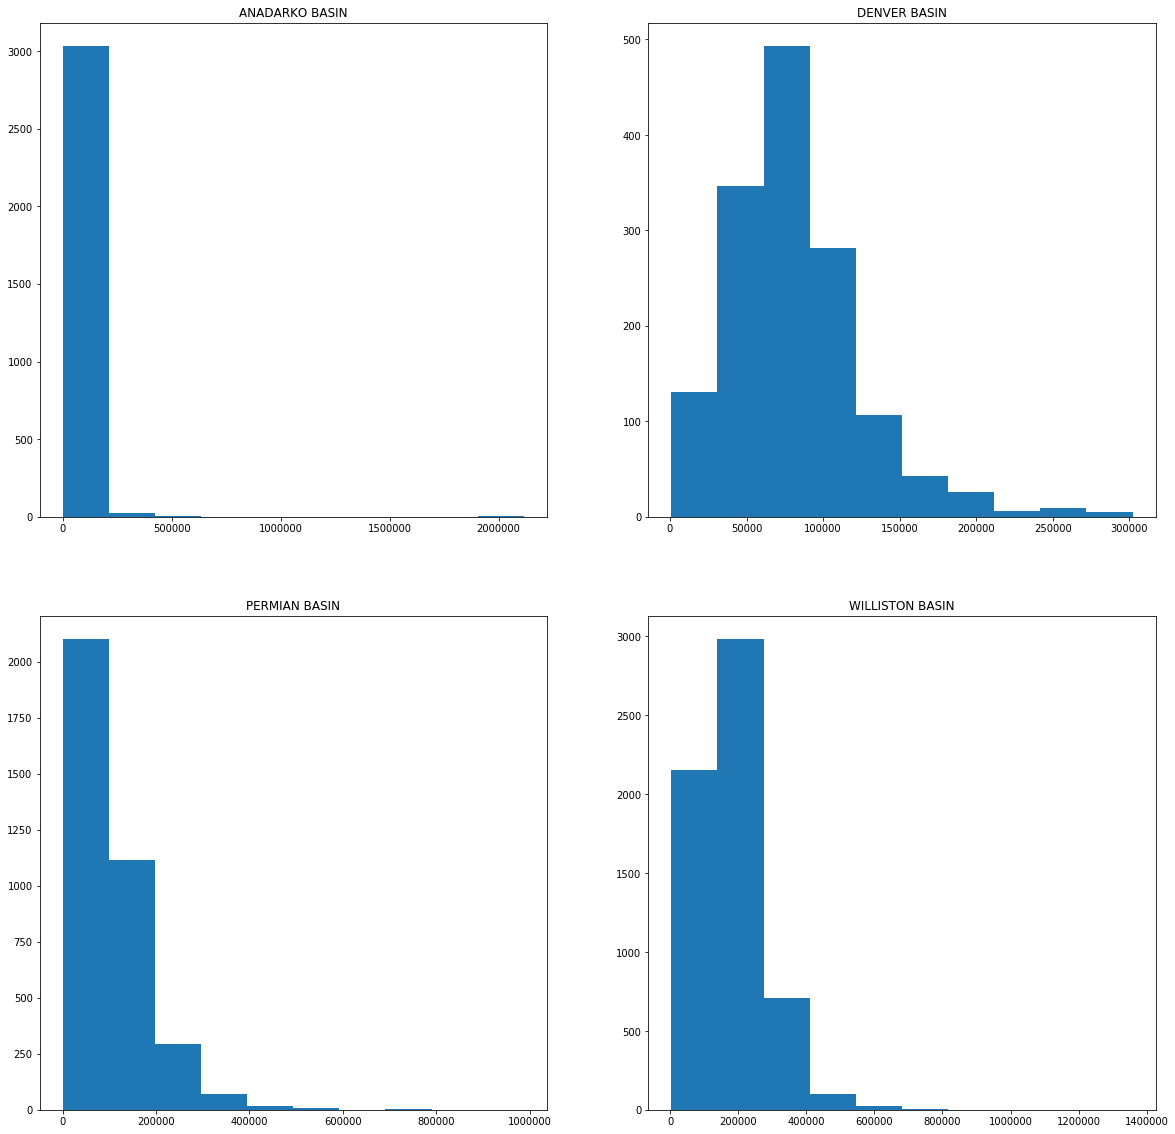

In [347]:
def cumm_prod_wells(table, basin):
    total = table[(table['BasinName'] == basin)]
    sums = total.groupby(total['API'])['Liquid'].sum()
    return sums

plt.rcParams["figure.figsize"] = 20,20
x = [cumm_prod_wells(five_years_data, y) for y in basins]

for i in range(len(basins)):
    ax1 = plt.subplot(2,2,i+1)
    ax1.hist(x[i])
    print(x[i].mean(), basins[i])
    ax1.set_title(basins[i])

plt.savefig('Plot3.png')
    
#print(cumm_prod_wells(five_years_data, "DENVER BASIN"))
# x = cumm_prod_wells(five_years_data, "ANADARKO BASIN")
# plt.hist(x)


In [255]:
#7asby Allah wn3ma elwakeel Method 2
mariem_prod = nesw_prod_data_orig.copy()
mariem_prod['total_month'] = mariem_prod['Year']*12 + mariem_prod['Month']
mariem_prod['total_max_month'] = mariem_prod['Max_Year']*12 + mariem_prod['Max_Month']
nourhan = mariem_prod[ mariem_prod['total_month'] >= mariem_prod['total_max_month']]
# nourhan = nourhan.drop_duplicates(['API', 'Liquid'], keep="first", inplace=False)
nourhan

,API,Year,Month,Liquid,Gas,RatioGasOil,Max_Year,Max_Month,Max_Liquid,total_month,total_max_month
3,35045231810000,2012,11,177,6259,35.361582,2012,11,177,24155,24155
4,35045231810000,2012,12,0,10666,0.000000,2012,11,177,24156,24155
5,35045231810000,2013,1,0,1500,0.000000,2012,11,177,24157,24155
6,33089006470100,2011,12,0,0,0.000000,2011,12,0,24144,24144
7,33089006470100,2012,1,0,0,0.000000,2011,12,0,24145,24144
8,35029211390000,2012,2,0,58971,0.000000,2012,2,0,24146,24146
9,35029211390000,2012,3,0,0,0.000000,2012,2,0,24147,24146
10,35029211390000,2012,4,0,0,0.000000,2012,2,0,24148,24146
11,35029211390000,2012,5,0,0,0.000000,2012,2,0,24149,24146
12,35029211390000,2012,6,0,0,0.000000,2012,2,0,24150,24146
